# E25. 사람이 말하는 단어를 인공지능 모델로 구분해보자

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import IPython.display as ipd
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

import librosa
import librosa.display

## 음성과 오디오 데이터
* 소리에서 얻을 수 있는 물리량
    - 진폭 (amplitude) (소리의 세기)
    - 주파수 (frequency) (소리의 높이)
    - 위상 (phase)
* 주파수 (the number of compressed)
    - 단위: Hz (1초에 진동하는 횟수)
    - 주파수가 높으면 높은 소리, 낮으면 낮은 소리가 남
* 주기 (period): 파동이 한 번 진동하는 데 걸리는 시간
    - sin함수의 주기는 2π/ω
* 복합파 (complex wave): 서로 다른 주파수를 가진 수많은 소리가 뒤섞여 만들어진 파형. 서로 다른 정현파 (sine wave) 들의 합으로 이루어짐
    - $x(n)\approx \sum_{k=0}^{K}a_k(n)cos(\phi _k(n))+e(n)$
        - where, $a_k$ = instantaneous amplitude
        - $\phi_k$ = instantaneous phase
        - $e(n)$ = residual (noise)

### 오디오 데이터의 디지털화
* 사인 함수 (sine function, 아날로그 신호 중 가장 단순한 형태): $Asin(2\pi ft - \phi)$
    - $A$: 진폭 (amplitude, 위아래로 움직이는 소리의 크기)
    - $f$: 주파수 (frequency, 초당 진동 횟수 or 소리의 세기) 주파수가 높으면 빠르게 진동해 소리의 세기가 커짐
    - $\phi$: 위상
    - $t$: 시간
   
#### 아날로그 신호의 표본화 (sampling)
* ```sampling_rate```: 초당 샘플링의 횟수
    - 나이키스트-섀넌 표본화에 따라 결정. 일반적으로는 16kHz (speech), 44.1kHz (music) 영역대가 많이 사용됨 https://linecard.tistory.com/20
    - 아날로그를 디지털로 거친 후 디지털을 아날로그로 왜곡없이 복원하기 위해서는, sampling rate는 입력 신호의 최고 주파수의 2배 이상 크게
    - 인간의 최대 가청 주파수가 20kHz이기 때문에, 음악의 sampling frequency는 나이키스트-섀넌 표본화에 따르면 40kHz가 기준이다. 다만 추가적인 이유를 더해 오디오 레코드에선 44.1kHz를 사용한다
* ```duration```: 지속시간 (단위: 초)

In [ ]:
def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

In [ ]:
# 1사이클 동안 나타나는 연속시간 연속크기 아날로그 신호 (사인함수)

plt.plot(y[:41])
plt.show()

In [ ]:
# 표본화 (sampling): 시간축 방향에서 일정 간격으로 샘플을 추출하여 이산 신호로 변환시키는 과정
# 1사이클 동안 나타나는 이산시간 연속크기 신호 

plt.stem(y[:41])
plt.show()

#### 표본화, 양자화, 부호화
* 표본화 (sampling): 아날로그 데이터에서 일정 간격으로 표본을 채취하는 방식으로 이산적 데이터를 구함
* 양자화 (quantizing): 디지털화를 위해서는 이산적 데이터의 값 자체가 소수점 아래로 무한히 정밀해질 수 없고, 일정 간격으로 값을 근사하여 구할 수밖에 없기 때문에 근사하는 과정
* 부호화 (encoding): 표본화 -> 양자화를 거친 원본 아날로그 수치를 0과 1로만 이루어진 디지털 표현으로 변환하는 과정

### wave data 분석
```
$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget http://bigfile.mail.naver.com/bigfileupload/download?fid=8QbZaAIq1NKXFoMjK3YXaxbwF3YZKAUmKxgwaxulFAMqFCYwFog9FquwFxvlHrMrpxg9KAtwFAt9K6K9F4udpx0oKxFvKxCoFq+vpo+0 -O speech_wav_8000.npz
$ mv speech_wav_8000.npz ~/aiffel/speech_recognition/data
```
   
#### wave 데이터 형식
* 오디오 데이터는 이미지 데이터보다 낮은 차원의 데이터를 다룬다
* 1개의 wav 파일은 1차원으로 이루어진 시계열 데이터이다
* 실제로는 여러 소리 파형이 합쳐진 복합파이다

#### 간단한 단어 인식을 위한 훈련 데이터셋
* 짧은 단어의 라벨이 달려 있어, 음성을 텍스트로 구분하는 모델 혹은 간단한 명령어를 구별하는 모델로도 학습이 가능하다

#### bits per sample
* 샘플 하나마다 소리의 세기를 몇 비트로 저장했는지를 나타낸다
* 값이 커질수록 세기를 정확하게 저장할 수 있다 (예: Bits rate가 16 bits 라면, 소리의 세기를 $2^{16}$, 즉 65536단계로 표현할 수 있다
* 4 bits / 8 bits unsigned int / 16 bits int / 24 bits / 32 bits float 등의 자료형으로 표현된다

#### sampling frequency
* 소리로부터 초당 샘플링 횟수를 의미한다
* 원래 신호를 다시 복원할 수 있는 나이키스트 샘플링 룰에 따라, 복원해야 할 신호 주파수의 2배 이상으로 샘플링해야 한다
* 가청 주파수 20~24kHz를 복원하기 위해 사용하며, 음원에서 많이 쓰이는 값은 44.1kHz이다

#### channel
* 각 채널별로 샘플링된 데이터가 따로 저장되어 있다
* 2채널 (stereo) 음원을 재생하면 왼쪽과 오른쪽 스피커에 다른 값이 출력된다
* 1채널 (mono) 음원의 경우 왼쪽 데이터만 있으며, 재생 시에는 왼쪽과 오른쪽 스피커에 같은 값이 출력된다

In [ ]:
data_path = 'speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# 데이터셋 살펴보기
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

* https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
* 데이터셋은 1초 길이의 음성 데이터 50620개로 이뤄져 있다
* 1초의 길이를 가지는 각각의 음성 데이터는 8000개의 sample data를 가지고 있다
* 주어진 데이터의 원래 sampling rate는 16000이지만, 8000으로 re-sampling해 사용한다

In [ ]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

## train/test 데이터셋 구성
* 단어의 정답 형태는 현재 텍스트. 학습을 위해 학습 가능한 형태로 만들어줘야 함
* 현재 라벨은 ```['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']``` (+ unknown, silience)

In [ ]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print("✅")

In [ ]:
# text -> index
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print("✅")

### 학습을 위한 데이터 분리

In [ ]:
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

In [ ]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

### hyperparameters setting
* 학습을 위한 하이퍼파라미터 설정 (```batch_size```, ```max_epochs```)
* 모델 체크포인트 저장을 위한 체크포인트 경로 설정 (모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용할 예정)

In [ ]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = 'speech_recognition/models/wav'
checkpoint_dir

### data setting

In [ ]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

In [ ]:
# tf.data.Dataset 함수 구성
# OOM?

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

## wave classification 모델 구현
### Model
* 오디오 데이터는 1차원이기 때문에 Conv1D 레이어 이용
* Conv, Batch Norm, Dropout, Dense 등을 이용해 모델 구성

In [ ]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

### Loss
* 라벨이 될 수 있는 단어 클래스 12개
* 클래스 구분 위해서는 multi-class classification 필요
* 이를 수행하기 위해 Loss로 Categorical Cross-Entropy loss를 사용

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

### Training
#### Callback
* 모델을 재사용하기 위해, 가중치를 저장하는 callback 함수 추가: model.fit 함수 이용할 때, callback 함수를 이용하면 학습 중간중간 원하는 동작 하도록 설정 가능
* ```ModelCheckpointCallback```: 학습을 진행하며 fit 함수 내 다양한 인자를 지정해 모니터하며 동작하게 설정
* 아래 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있음

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

In [ ]:
# 30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

In [ ]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [ ]:
model_wav.load_weights(checkpoint_dir)
print("✅")

In [ ]:
results = model_wav.evaluate(test_dataset)
print("✅")

In [ ]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

## skip-connection model 추가
* 이미지 처리에서 안정적으로 높은 성능을 냈던 ResNet 등 skip-connection 을 활용한 모델 추가

In [ ]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

In [ ]:
# the save point
checkpoint_dir = 'speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

In [ ]:
# 30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

In [ ]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [ ]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

## Spectrogram
* 많은 음원의 파형이 합성된 복합파인 waveform 보다 뚜렷하게 주파수 대역별로 나누어 별도로 해석해볼 수 없을까?

### Fourier Transform
* 푸리에 변환 (Fourier Transform): 임의의 입력 신호를 다양한 주파수를 갖는 주기함수 (복수 지수함수) 들의 합으로 분해하여 표현하는 방법
* $A_k = \frac{1}{T}\int_{-\frac{T}{2}}^{\frac{T}{2}}f(t)exp(-i\cdot 2\pi\frac{k}{T}t)dt$   

#### 오일러 공식 (지수함수와 주기함수의 관계)   
* $e^{i\theta} = cos\theta + isin\theta$  
$exp(i \cdot 2\pi\frac{k}{T}t) = cos(2\pi\frac{k}{T}) + jsin(2\pi\frac{k}{T})$
    - $cos2\pi kT$, $jsin2\pi kT$ 는 주기와 주파수를 가지는 주기함수
    - 푸리에 변환은 입력 시그널이 어떤 것인지와 상관 없이 sin, cos 같은 주기함수들의 합으로 항상 분해가 가능하다는 뜻
    - 푸리에 변환의 결과는 실수부와 허수부를 가지는 복소수 (= spectrum magnitude)
    - 복소수가 가지는 phase는 phase spectrum (주파수의 위상)   
   
#### STFT (Short Time Fourier Transform)
* 시간의 길이를 나눠서 푸리에 변환. FFT의 한계 (시간의 흐름에 따라 신호의 주파수가 변했을 때, 어느 시간대에 주파수가 변하는지 모르는 것) 를 극복하기 위한 방법
* $X(l,k)=\sum_{n=0}^{N-1}\omega (n)x(n+lH)exp^{\frac{-2\pi kn}{N}}$
    - N: FFT size (window를 얼마나 많은 주파수 밴드로 나누는가)
    - Duration: sampling rate를 window로 나눈 값 (T = window / sampling rate). duration은 신호 주기보다 5배 이상 길게 잡아야 한다 (T(window) = 5T(signal)
    - $\omega(n)$: window 함수. 일반적으로는 hann window가 많이 쓰임
    - n: window size (window 함수에 들어가는 sample의 양). n이 작을수록 low-frequency resolution, high-time resolution을 가지게 된다. n이 길수록 high-frequency, low-time resolution을 가진다
    - H: hop size (window가 겹치는 사이즈). 일반적으로는 1/4 정도를 겹치게 한다
* STFT의 결과는 시간의 흐름에 따른 frequency 영역별 amplitude 를 반환

### Spectrogram 
```
$ pip install librosa
```
   
* 1차원 waveform 데이터 -> 2차원 spectrogram 데이터로 변환

In [2]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [ ]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 프로젝트: Spectrogram Classification 모델 구현

### 데이터 처리와 분류

In [3]:
data_path = 'speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# 데이터셋 살펴보기
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  36407
Wave data shape :  (8000,)
label :  ['stop']


In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print("✅")

✅


In [6]:
# text -> index
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print("✅")

✅


In [7]:
spec_data = []

for w in speech_data["wav_vals"]:
    spec_data.append(wav2spec(w))
    
spec_data = np.array(spec_data)
print(spec_data.shape)

(50620, 130, 126)


In [8]:
sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec_data[:25000], 
                                                                label_data[:25000], 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])

print("✅")

[[[5.08931339e-01 2.01986894e-01 1.32217512e-01 ... 2.21156135e-01
   5.25393367e-01 8.75150263e-01]
  [8.07675719e-01 4.92411911e-01 5.12466908e-01 ... 7.48297513e-01
   5.94863594e-01 1.26033401e+00]
  [7.75464416e-01 8.36454630e-01 8.88581693e-01 ... 1.29680812e+00
   1.28772008e+00 1.35152495e+00]
  ...
  [7.89303705e-03 4.00979910e-03 3.32690615e-05 ... 3.58254110e-05
   6.26447087e-04 1.10462273e-03]
  [7.85328727e-03 3.96507699e-03 6.58431918e-06 ... 3.60897575e-05
   7.49636209e-04 1.38862699e-03]
  [7.82783516e-03 3.95877287e-03 1.98068096e-06 ... 3.11955228e-05
   7.84916512e-04 1.47676584e-03]]

 [[1.54194329e-02 1.12961456e-02 3.54966731e-04 ... 2.48937914e-03
   7.15553900e-03 5.09624952e-04]
  [9.10431799e-03 7.98935816e-03 6.72457973e-03 ... 1.65408552e-02
   1.12899998e-02 1.03259729e-02]
  [3.25554429e-04 2.36154557e-03 2.62165139e-03 ... 9.90008339e-02
   4.22796868e-02 9.02250409e-03]
  ...
  [8.59413049e-05 6.28370399e-05 3.25575093e-05 ... 2.02741885e-05
   5.94700

In [9]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (22500, 130, 126)
train labels :  (22500,)
test data :  (2500, 130, 126)
test labels :  (2500,)
✅


### 학습을 위한 하이퍼파라미터 설정

In [10]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = 'speech_recognition/models/wav/prj'
checkpoint_dir

'speech_recognition/models/wav/prj'

In [11]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


### 데이터셋 구성
* tf.data.Dataset을 이용
* from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
* map과 batch를 이용한 데이터 전처리

In [12]:
# tf.data.Dataset 함수 구성
# OOM?

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


### 2차원 spectrogram 데이터를 처리하는 모델 구성
* 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
    - batchnorm, dropout, dense layer 등을 이용
    - 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
    - 모델 가중치를 저장하는 checkpoint callback 함수 추가

In [13]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)           

In [14]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


### 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
* loss, accuracy를 그래프로 표현

In [16]:
# 30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
174/175 [============================>.] - ETA: 0s - loss: 1.8428 - accuracy: 0.3768
Epoch 00001: val_loss improved from inf to 2.24931, saving model to speech_recognition/models/wav/prj
175/175 [==============================] - 3s 17ms/step - loss: 1.8394 - accuracy: 0.3779 - val_loss: 2.2493 - val_accuracy: 0.4885
Epoch 2/10
173/175 [============================>.] - ETA: 0s - loss: 1.1761 - accuracy: 0.5954
Epoch 00002: val_loss improved from 2.24931 to 1.59118, saving model to speech_recognition/models/wav/prj
175/175 [==============================] - 3s 16ms/step - loss: 1.1739 - accuracy: 0.5962 - val_loss: 1.5912 - val_accuracy: 0.6357
Epoch 3/10
173/175 [============================>.] - ETA: 0s - loss: 0.8843 - accuracy: 0.6962
Epoch 00003: val_loss improved from 1.59118 to 0.95906, saving model to speech_recognition/models/wav/prj
175/175 [==============================] - 3s 16ms/step - loss: 0.8819 - accuracy: 0.6969 - val_loss: 0.9591 - val_accuracy: 0.7056
Ep

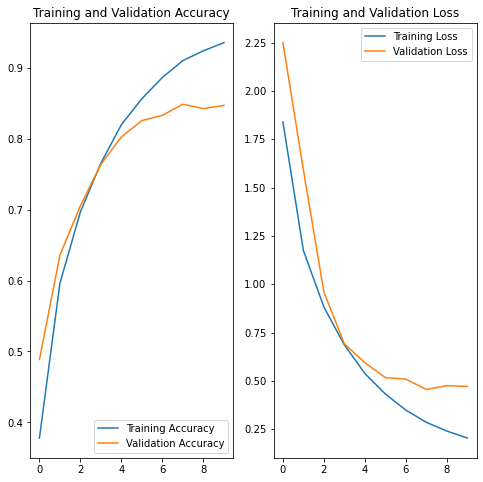

✅


In [17]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [18]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [19]:
results = model_wav.evaluate(test_dataset)
print("✅")

20/20 [==============================] - 6s 303ms/step - loss: 0.4543 - accuracy: 0.8488
✅


In [20]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.454
accuracy value: 84.8800%
✅


In [23]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  up


In [24]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: up
✅
